# Matrix Completion Experimentation 
In this notebook, we hope to present a wide variety of experiments that will be useful to analyzing the efficacy and performance of the matrix completion method in predicting joke ratings for a given user.

As of now, there will be little exposition and mostly plots and data, but we will hope to include more written analysis
interspersed with informative figures.

## Setting up our Environment
We will be testing out various methods which have been implemented for producing some basic metrics regarding the matrix
completion methods. Before we do so, we will set up our environment with the basic tools for analyzing and plotting data, i.e., `numpy`, `matplotlib`, and `pandas`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib notebook

Now we will read in the data. We have three frames of data which are pulled from a sql database currently. These are pulled in with the old_read_clean_data function in the user module.

In [2]:
import user
raters, ratings, jokes = user.old_read_clean_data('jokedb.sqlite3')

These frames have the following structure:

In [3]:
raters.head()

,gender,age,birth_country,major,preferred_joke_genre,preferred_joke_genre2,preferred_joke_type,favorite_music_genre,favorite_movie_genre
id,,,,,,,,,
453,Male,20,United States,Computer Science/CSE,Nerd,School,Puns,Hip-Hop,Comedy
454,Female,25,China,Physics,Animal,Math,Punch line,Pop,SciFi
455,Male,21,United States,Computer Science/CSE,Programming,Animal,Puns,Jazz,Thriller
456,Male,22,United States,Computer Science/CSE,Nerd,Programming,Question,Hip-Hop,SciFi
457,Male,23,United States,Computer Science/CSE,Nerd,Programming,Puns,Alternative Rock,SciFi


In [4]:
ratings.head()

joke_id,505,506,507,508,509,511,512,513,514,515,...,655,658,659,660,661,663,664,665,666,667
joke_rater_id,,,,,,,,,,,,,,,,,,,,,
453,2.0,4.0,2.0,3.0,1.0,2.0,3.0,3.0,4.0,3.0,...,2.0,3.0,3.0,3.0,3.0,2.0,3.0,2.0,3.0,2.0
457,3.0,5.0,3.0,3.0,5.0,3.0,4.0,4.0,5.0,5.0,...,1.0,5.0,5.0,4.0,3.0,5.0,5.0,4.0,1.0,4.0
458,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,3.0,4.0,...,1.0,4.0,1.0,3.0,1.0,3.0,2.0,1.0,1.0,1.0
459,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
460,4.0,4.0,5.0,2.0,2.0,4.0,2.0,3.0,4.0,5.0,...,4.0,4.0,2.0,3.0,2.0,3.0,4.0,3.0,4.0,3.0


In [5]:
jokes.head()

,category,joke_type,subject,joke_text,joke_submitter_id,joke_source
id,,,,,,
505,Sports,pun,Tennis,Why don’t fish play tennis? Because they're af...,NaN,D94
506,Programming,One-liner,Recursion,"To understand what recursion is, you must firs...",496.0,C37
507,Other,Punch-line,Onions,A lot of people cry when cutting onions. The t...,533.0,C75
508,Lawyer,punch line,east coast,Why does New Jersey have so many toxic waste d...,NaN,D80
509,School,One-liner,school,I start studying when my coffee starts kicking...,468.0,C11


So we see that that the raters and jokes are each uniquely identified by a rater id and joke id respectively. Within these frames, we have a collection of features which describe the raters and jokes (to varying degrees of usefulness). The ratings dataframe is simply a matrix of the ratings each rater has given each joke.

To get a clearer picture for how the data is structured, we can produce get some quick information from the dataframe.

First how many users and how many jokes there are

In [6]:
ratings.shape

(95, 153)

How many missing values there are:

In [7]:
ratings.isnull().sum().sum()

399

All things considered, 399 missing entries out of 95 * 153 = 14535 is roughly 3% of the data which is not too bad.

Here is a visualization of the ages of the users. The users are clearly centered around 20-22 with some outliers being closer to 30. Totally unsurprising.

<IPython.core.display.Javascript object>


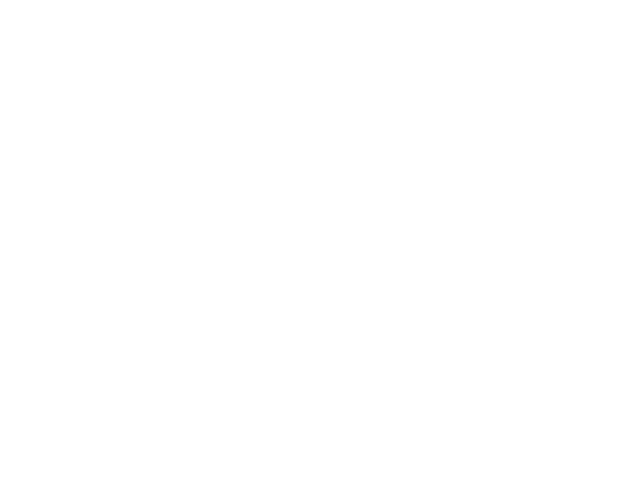

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb83735f860>]], dtype=object)

In [8]:
raters.hist('age')

Here is a visualization of the ratings that the users gave themselves.


<IPython.core.display.Javascript object>


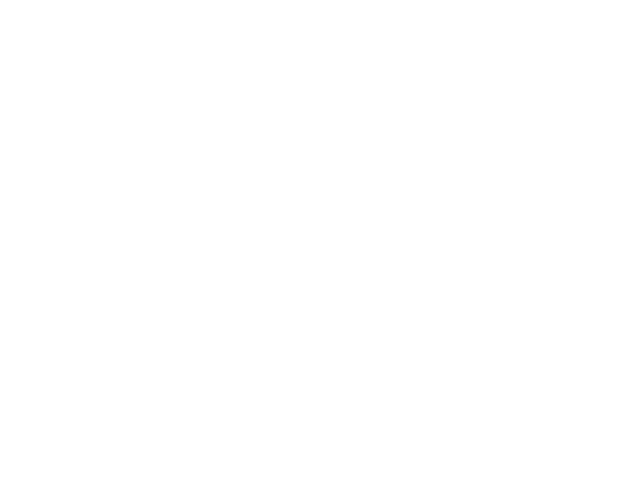

Text(0.5,1,'Ratings of Jokes by ECS171 Class')

In [9]:
fig, axis = plt.subplots()
heatmap = axis.pcolor(ratings.values)
fig.colorbar(heatmap)
axis.set_xlabel('Jokes')
axis.set_ylabel('Users')
axis.set_title('Ratings of Jokes by ECS171 Class')

In this plot, we can see that some users were clearly much more lenient with their ratings than others. From the plot itself, we can see that certain users were inclined to rate everything in the 1-2 range whereas others wanted to rate everything in the 4-5 range. These are evident from the blue and yellow horizontal lines.

We also see the presence of missing data as evidenced by the white streaks located across the heatmap.

An inference to be made might be that the users themselves are better predictors of whether they will rate a joke highly or not than the joke itself. There seem to be more patterns horizontally, then there are vertically. Few jokes seem to be considered funny by the population as a whole.

## Rating Predictions
In the next section, we will present a few methods for analyzing the success of the different methods used for predicting ratings from a given user. In all cases, our metric of choice is mean square error (although other metrics may fare well including MAE, or other Lp norms). For our intents and purposes, a method which minimizes the mean square error is one which performs the best. There are perhaps valid reasons to consider other metrics, say maximum error, for mean square error may not capture extreme cases which we wish to avoid (like presenting a 1-rating when it should be 5), but on average, it performs best.

### Cross-Validation
To determine the efficacy of our methods, we will perform cross validation on the predicted ratings. To this end, we adopt a leave-one-out scheme wherein we will take one user out of the user frame and wipe this user's ratings. Then we will apply a matrix completion algorithm to fill in this user's ratings. Then to determine the accuracy of the results we will compute the mean squared error between the predicted ratings for this user and his actual ratings.

To see this in action, we have the `MatrixTester` class in the `metrics` module

In [10]:
import metrics
matrix_tester = metrics.MatrixTester(ratings, raters)

We have constructed an object which will encapsulate all the information about the raters, ratings, and the parameterizations of the specific algorithm we are interested in. Then to run the algorithm, we simply need to call the `run` method to produce all the errors for each of the users.

In [11]:
errors = matrix_tester.run()

We can now get a quick visualization about the errors for this specific run.

<IPython.core.display.Javascript object>


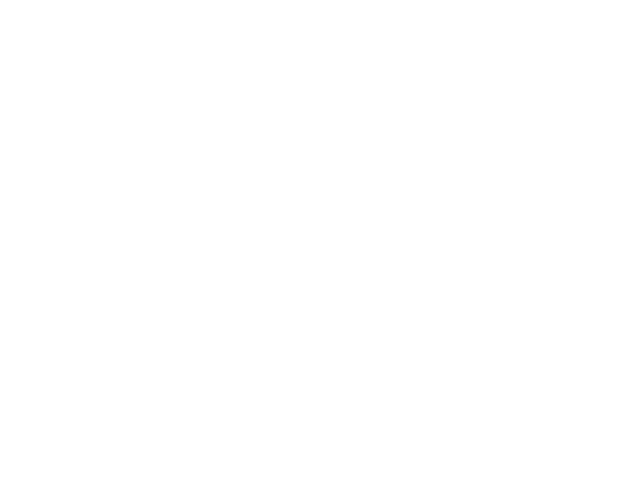

(array([ 10.,  13.,   7.,  18.,  20.,   6.,   7.,   8.,   1.,   5.]),
 array([ 0.52180964,  0.79288771,  1.06396577,  1.33504383,  1.60612189,
         1.87719995,  2.14827802,  2.41935608,  2.69043414,  2.9615122 ,
         3.23259027]),
 <a list of 10 Patch objects>)

In [12]:
plt.subplots()
plt.hist(errors, bins=10)

In [13]:
np.mean(errors)

1.6294358220417067

The mean of the errors is about 1.63 which means that on average, the method is off by a little more than 1 in what it rates the items. From the histogram plot, we see that it is not too uncommon to get a mean square error over 3. 

Since the ratings range from 1-5, we see that a benchmark for average performance might be a mean square error of 4, since if we were to predict 3 every time, we would have a maximum square error of 4. Anything which is close to 4 leaves something to be desired and if we get anything higher than 4, it might be more advantageous to do the opposite prediction of our method.

A couple comments about the above method are in order as well. By default, the matrix completion defaults to mean which means that missing values are simply computed as the mean of the column. This might explain why we would expect average performance.

In addition, the method by default also samples 5 ratings to so that the user does not completely start anew.

We can see the performance of separate methods by modifying the parameters of the tester. We can modify the sample size with the argument sample_size and change the completion method with the completer argument.

In [14]:
one_sample_tester = metrics.MatrixTester(ratings, raters, sample_size=1)

In [15]:
errors = one_sample_tester.run()

In [16]:
np.mean(errors)

1.6752448059562339

Not much difference, but this is to be expected as the mean method does not take into account information from the rows.

Some other methods of completing the matrix are presented as well along with their errors.

### Iterative SVD


In [17]:
iterative_svd = metrics.MatrixTester(ratings, raters, completer='iterativeSVD')

In [18]:
svd_errors = iterative_svd.run()

In [19]:
np.mean(svd_errors)

2.0748689825938564

<IPython.core.display.Javascript object>


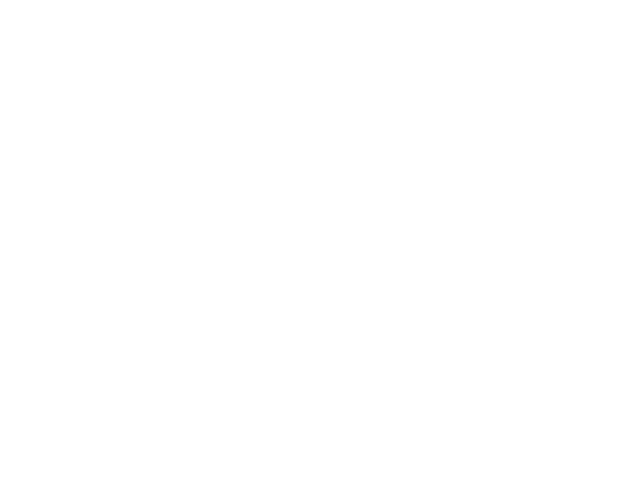

(array([  5.,  12.,  17.,  21.,  20.,   7.,   8.,   4.,   0.,   1.]),
 array([ 0.02460494,  0.57521864,  1.12583235,  1.67644605,  2.22705975,
         2.77767346,  3.32828716,  3.87890086,  4.42951457,  4.98012827,
         5.53074197]),
 <a list of 10 Patch objects>)

In [20]:
plt.subplots()
plt.hist(svd_errors)

### SoftImpute


In [21]:
imputer = metrics.MatrixTester(ratings, raters, completer='soft_impute')
impute_errors = imputer.run()

In [22]:
np.mean(impute_errors)

3.0071696977863134

<IPython.core.display.Javascript object>


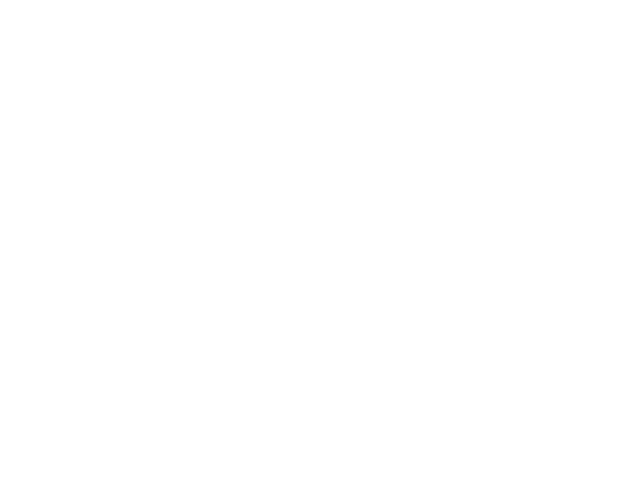

(array([  6.,  12.,   9.,  24.,  20.,  12.,   7.,   2.,   1.,   2.]),
 array([  3.07522300e-03,   7.63638642e-01,   1.52420206e+00,
          2.28476548e+00,   3.04532890e+00,   3.80589232e+00,
          4.56645574e+00,   5.32701916e+00,   6.08758257e+00,
          6.84814599e+00,   7.60870941e+00]),
 <a list of 10 Patch objects>)

In [23]:
plt.subplots()
plt.hist(impute_errors)

### KNN

In [24]:
knn = metrics.MatrixTester(ratings, raters, completer='KNN')
knn_errors = knn.run()

In [25]:
np.mean(knn_errors)

1.6330372587056314

<IPython.core.display.Javascript object>


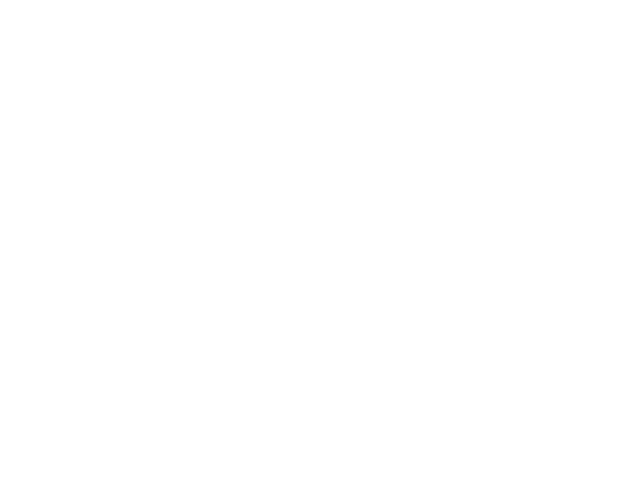

(array([  2.,  10.,  16.,  18.,  23.,  12.,   7.,   3.,   3.,   1.]),
 array([ 0.18300595,  0.53454492,  0.8860839 ,  1.23762288,  1.58916185,
         1.94070083,  2.2922398 ,  2.64377878,  2.99531775,  3.34685673,
         3.69839571]),
 <a list of 10 Patch objects>)

In [26]:
plt.subplots()
plt.hist(knn_errors)

### Random

In [27]:
gauss = metrics.MatrixTester(ratings, raters, completer='gauss')
gauss_errors = gauss.run()

In [28]:
np.mean(gauss_errors)

3.2179846703454333

<IPython.core.display.Javascript object>


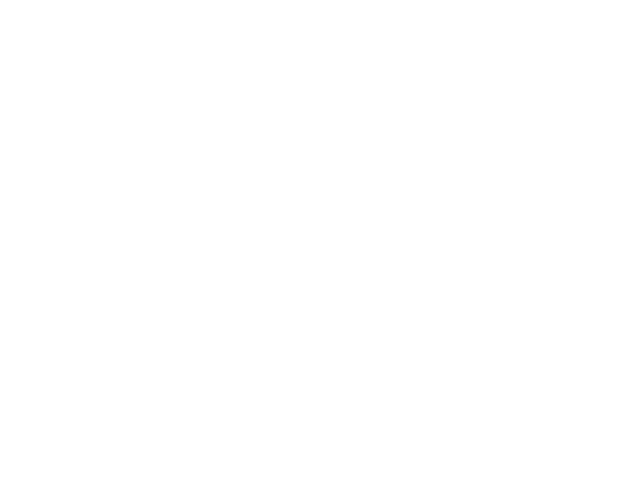

(array([  5.,  17.,  11.,  19.,  21.,   9.,   4.,   4.,   1.,   4.]),
 array([ 1.91999139,  2.25502784,  2.5900643 ,  2.92510075,  3.26013721,
         3.59517367,  3.93021012,  4.26524658,  4.60028303,  4.93531949,
         5.27035595]),
 <a list of 10 Patch objects>)

In [29]:
plt.subplots()
plt.hist(gauss_errors)

### Active Learning
Now our algorithms will not only be fit to a small sample of user ratings. Should a user so desire, he can continue to rate jokes to his heart's content and in theory, the ratings should improve over time. To capture this effect we have implemented the tester `IncrementalTester` which incrementally updates the model of predictions for the user by running the matrix completion algorithm for each joke the user rates.

It computes the mean square error at each of these steps, so we will be able to trace the performance of the ratings over time.

In [30]:
mean_tester = metrics.IncrementalTester(ratings, raters)

In [31]:
mean_tester.fit()
errors = mean_tester.run()

<IPython.core.display.Javascript object>


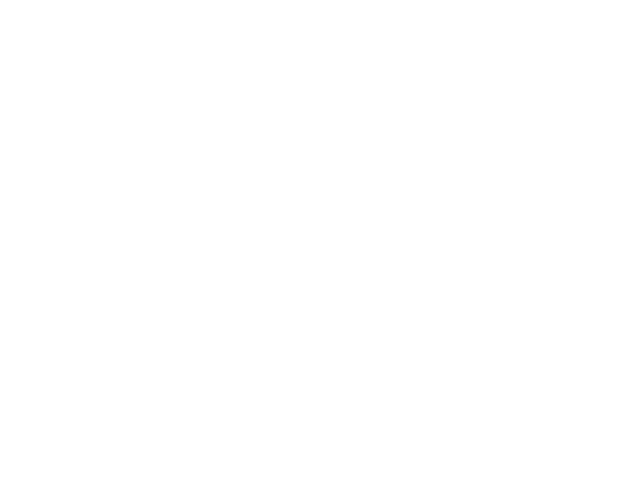

In [32]:
plt.subplots()
plt.plot(errors)

So we see that the ratings do get better over time. But is this due to the model simply knowing more ratings because the user tells it to the model? Or is it actually improving over time after each rating?

We can examine this and other facts by looking at the various methods of completing the matrix.

### IterativeSVD

In [33]:
iterative_svd_tester = metrics.IncrementalTester(ratings, raters, completer='iterativeSVD')
iterative_svd_tester.fit()
svd_errors = iterative_svd_tester.run()

<IPython.core.display.Javascript object>


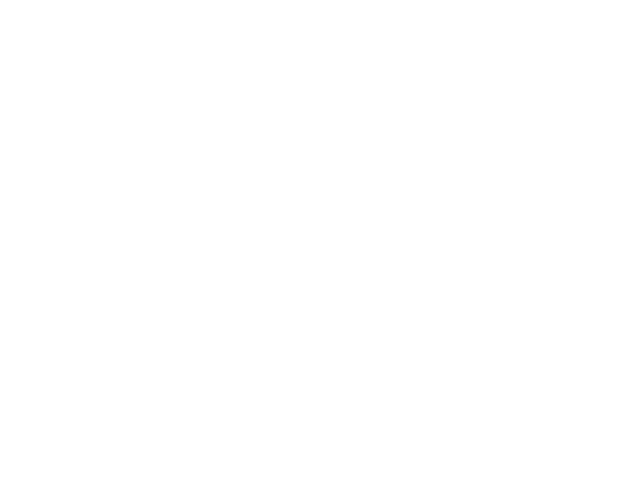

In [34]:
plt.subplots()
plt.plot(svd_errors)

### Soft Impute

In [35]:
soft_imputer = metrics.IncrementalTester(ratings, raters, completer='soft_impute')
soft_imputer.fit()
soft_errors = soft_imputer.run()

<IPython.core.display.Javascript object>


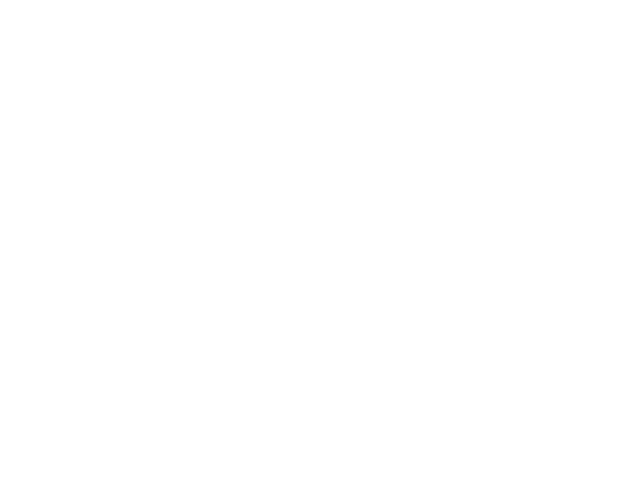

In [36]:
plt.subplots()
plt.plot(soft_errors)

### KNN

In [37]:
knn = metrics.IncrementalTester(ratings, raters, completer='KNN')
knn.fit()
knn_errors = knn.run()

[KNN] Warning: 153/14535 still missing after imputation, replacing with 0


<IPython.core.display.Javascript object>


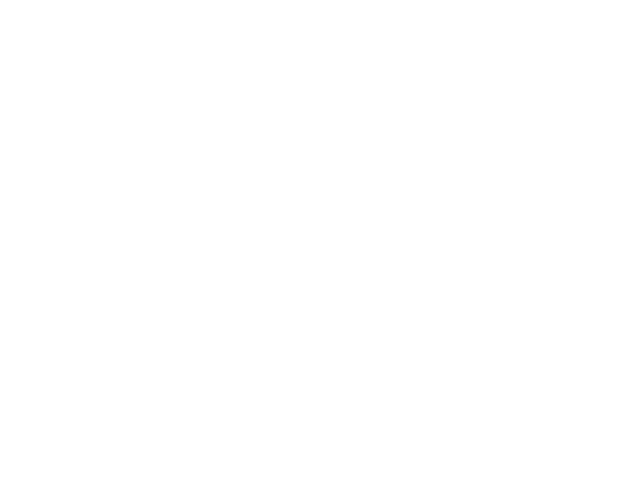

In [38]:
plt.subplots()
plt.plot(knn_errors)

### Random

In [39]:
gauss = metrics.IncrementalTester(ratings, raters, completer='gauss')
gauss.fit()
gauss_errors = gauss.run()

<IPython.core.display.Javascript object>


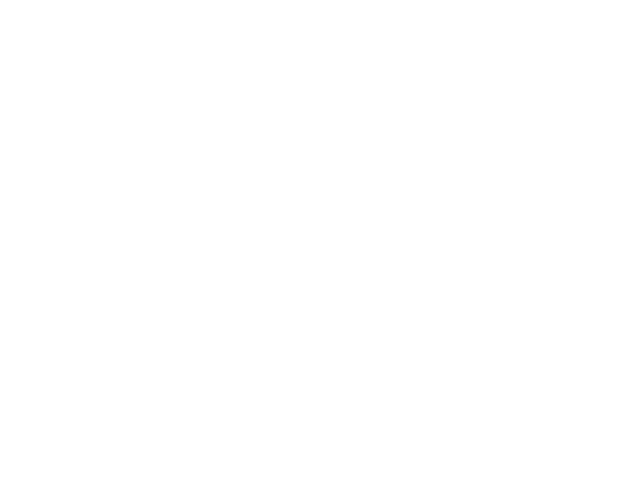

In [40]:
plt.subplots()
plt.plot(gauss_errors)

As a means of comparison, here are all these methods on the same plot.

<IPython.core.display.Javascript object>


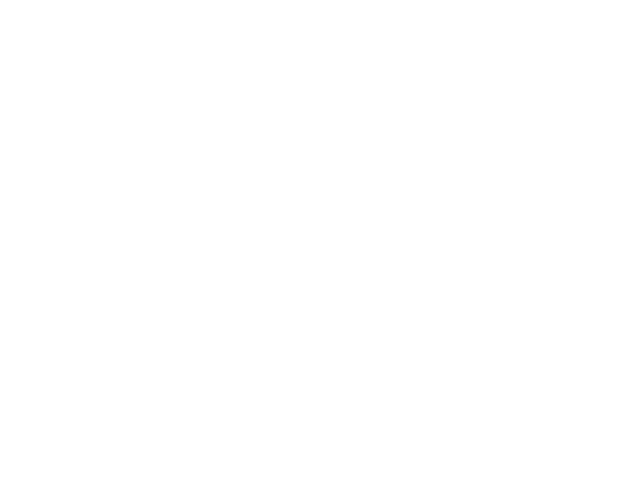

In [41]:
plt.subplots()
plt.plot(errors, label='mean')
plt.plot(svd_errors, label='IterativeSVD')
plt.plot(soft_errors, label='soft_impute')
plt.plot(knn_errors, label='KNN')
plt.plot(gauss_errors, label='random')
plt.legend()

<IPython.core.display.Javascript object>


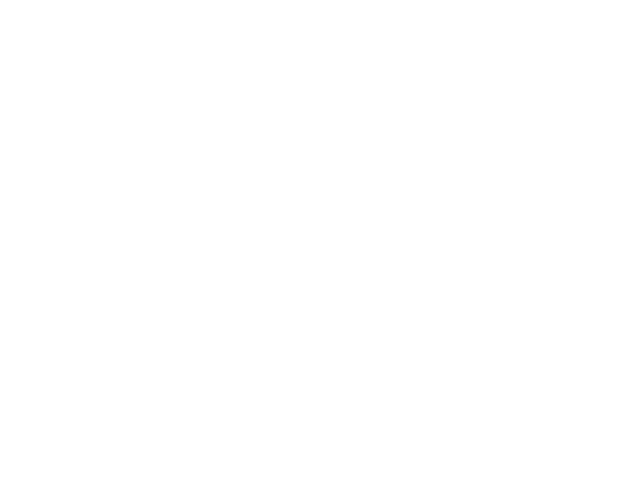

[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing

Text(0.5,1,'Performance of Recommender System as More Ratings are Received')

In [42]:
tester = knn
fig, axis = plt.subplots()
for _ in range(40):
    tester.fit()
    errors = tester.run()
    axis.plot(errors, color='blue', alpha=0.1)
axis.set_ylabel('Mean Squared Error')
axis.set_xlabel('Iteration Number')
axis.set_title('Performance of Recommender System as More Ratings are Received')

It is also worth noting that the performance of these methods can very greatly. Here is the KNN method applied to 100 different rows.

<IPython.core.display.Javascript object>


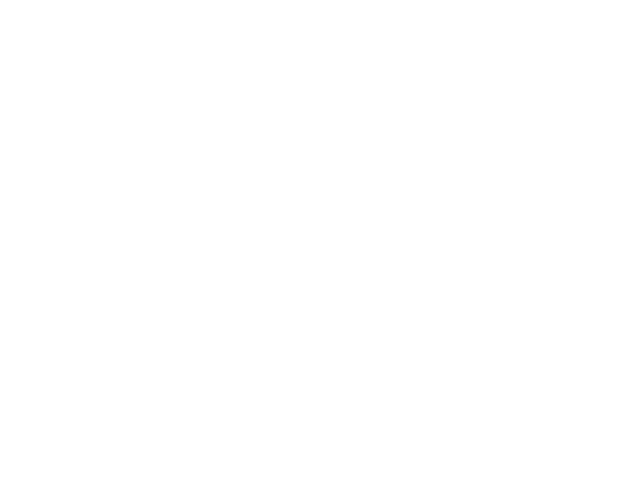

KeyboardInterrupt: 

In [43]:
testers = [mean_tester, iterative_svd_tester, soft_imputer, knn, gauss]
names = ['mean', 'iterativeSVD', 'soft_impute', 'KNN', 'random']
colors = ['red', 'orange', 'blue', 'green', 'purple']
fig, axes = plt.subplots()
mean_errors = {}
for tester, name, color in zip(testers, names, colors):
    all_errors = []
    for _ in range(40):
        tester.fit()
        errors = tester.run()
        all_errors.append(errors)
    mean_error = np.mean(all_errors, axis=0)
    mean_errors[name] = mean_error
    axes.plot(mean_error, color=color, label=name)
    axes.set_ylabel('Mean Square Error')
    axes.set_xlabel('Number of Jokes Known')
    axes.set_title('Mean Square Error Averaged over 40 Iterations')
axes.legend()

In [ ]:
np.mean([[1,2],[3,4]], axis=0)

In [ ]:
mean_errors

# Fine Tuning The Algorithm

Now that we see that the K-nearest-neighbors algorithm seems to perform the best, we might wish to try to fine-tune the specific parameters of the algorithm. Specifically we want to determine exactly how varying K will affect the performance of the algorithm.

To this end, we have a specific tester for the KNN algorithm specifically. We will use the class `KNNTester` for producing error metrics.

In [16]:
from metrics import KNNTester

In [17]:
errors = []
for k in range(1, 51):
    tester = KNNTester(ratings, raters, k)
    errors.append(np.mean(tester.run()))

[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0


In [6]:
tester = KNNTester(ratings, raters, 5)
tester.run()

[KNN] Warning: 153/14535 still missing after imputation, replacing with 0


[0.76334253363789795,
 1.4747019867549669,
 1.0326736052607948,
 0.10947640933559004,
 1.3510224698523883,
 1.7066422028106882,
 2.3311101462598529,
 1.5616101147629198,
 1.9120607872884776,
 1.4173855145686582,
 2.4992578361813615,
 2.3430769230769228,
 3.132436772626519,
 1.3318657065621022,
 1.1022371648999922,
 1.2755065190648855,
 2.1245312691593519,
 0.60197708231215474,
 1.2070748299319727,
 1.2749927834605399,
 1.3427654852468878,
 1.6379084967320261,
 2.0130598400048454,
 2.093248655192566,
 1.704472857379749,
 1.8998155656300288,
 1.617283950617284,
 0.94342805710139577,
 1.0126096491228069,
 2.5717556136477837,
 1.7066960697035023,
 1.22667863518927,
 0.70788315326130458,
 1.415699564940184,
 2.1958145919241665,
 2.2591316618365829,
 0.95909377260649575,
 2.9315177673821817,
 1.8515688271485642,
 2.0215481611527872,
 1.4375551865335328,
 1.1999170038385725,
 2.2423848489671196,
 0.7538666666666668,
 0.75031054804934538,
 0.95776905145479285,
 1.1977332130996159,
 1.582221961

<IPython.core.display.Javascript object>


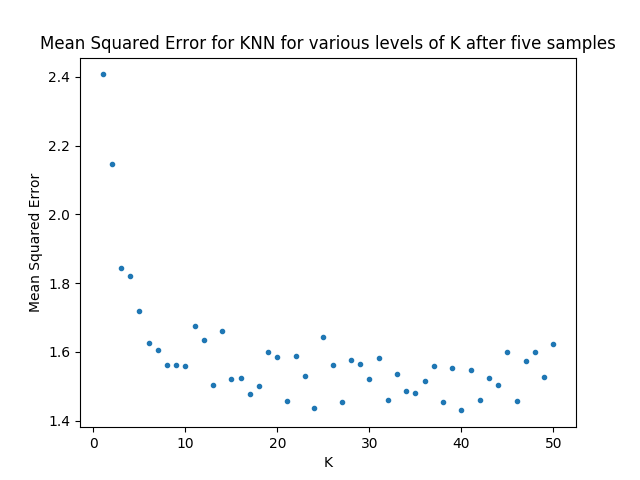

Text(0.5,1,'Mean Squared Error for KNN for various levels of K after five samples')

In [18]:
fig, axis = plt.subplots()
axis.plot(list(range(1, 51)), errors, '.')
axis.set_ylabel('Mean Squared Error')
axis.set_xlabel('K')
axis.set_title('Mean Squared Error for KNN for various levels of K after five samples')

In [24]:
errors5 = errors

Notice there is quite a bit of variance in the results. This is in part due to the sampling method introducing noise and each cross-validation method works with different samples leading to a distribution of results. If we want some more control over how it is sampled to get some form of determinism, we can define our own seeded sampler. This way each test, we will get the same sample for each run.

In [7]:
import random

def seeded_sampler(seed=100, sample_size=5):
    random.seed(seed)
    
    sample = random.sample(jokes.index.tolist(), sample_size)
    for x in sample:
        yield x

class SeededSampler:
    def __init__(self, seed=100, sample_size=5):
        self.sample = seeded_sampler(seed, sample_size)
    
    def __call__(self):
        return next(self.sample)

In [8]:
errors = []
for k in range(1, 51):
    sampler = SeededSampler()
    tester = KNNTester(ratings, raters, k, sampler=sampler)
    errors.append(np.mean(tester.run()))

[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0


<IPython.core.display.Javascript object>


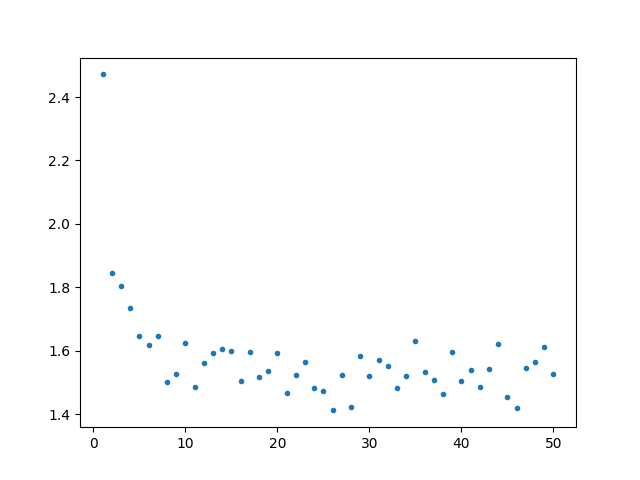

In [10]:
plt.plot(list(range(1, 51)), errors, '.')

In [13]:
plt.hist()

<function matplotlib.pyplot.hist>

We also try this should we have ten samples instead of five, to see if we can better discern results at that level.

In [21]:
errors10 = []
for k in range(1, 51):
    sampler = SeededSampler(sample_size=10)
    tester = KNNTester(ratings, raters, k, sampler=sampler, sample_size=10)
    errors10.append(np.mean(tester.run()))

[KNN] Warning: 153/14535 still missing after imputation, replacing with 0
[KNN] Warning: 153/14535 still missing after imputation, replacing with 0


<IPython.core.display.Javascript object>


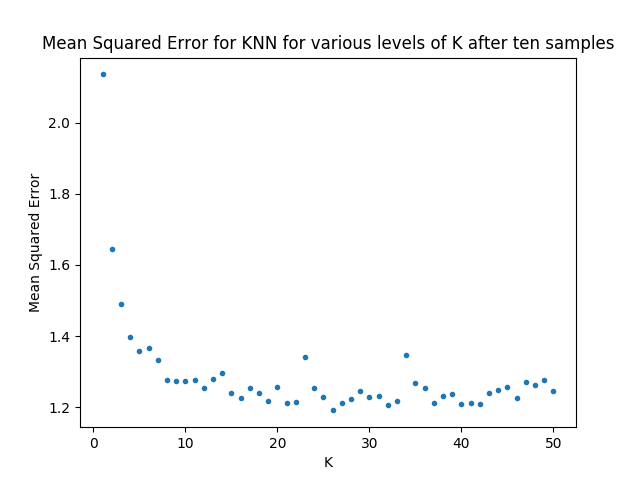

Text(0.5,1,'Mean Squared Error for KNN for various levels of K after ten samples')

In [22]:
fig, axis = plt.subplots()
axis.plot(list(range(1, 51)), errors10, '.')
axis.set_ylabel('Mean Squared Error')
axis.set_xlabel('K')
axis.set_title('Mean Squared Error for KNN for various levels of K after ten samples')

<IPython.core.display.Javascript object>


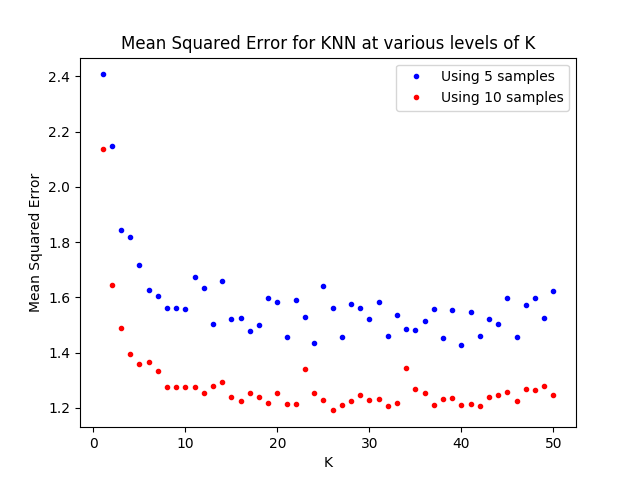

Text(0.5,1,'Mean Squared Error for KNN at various levels of K')

In [25]:
fig, axis = plt.subplots()
axis.plot(list(range(1, 51)), errors5, 'b.', label='Using 5 samples')
axis.plot(list(range(1, 51)), errors10, 'r.', label='Using 10 samples')
axis.legend()
axis.set_xlabel('K')
axis.set_ylabel('Mean Squared Error')
axis.set_title('Mean Squared Error for KNN at various levels of K')

For the most part the errors appears to be a decreasing sequence in k up until a certain point where the errors flatten out. In order to minimize computation, we would want to pick k as small as possible while still minimizing the error.
To do so we adopt a heuristic. Since the errors appear to flatten out eventually until it possibly increases for large k, we might try to pick k such that the average of (e_k, e_k+1, ..., e_k+9) is minimized.

In [26]:
def smallest_average_window(values, n=10):
    """
    This function finds index k such that the average of values[k:k+n] is minimized
    """
    smallest = np.inf
    smallest_k = 0
    for k in range(len(values) - n):
        avg = np.mean(values[k:k+n])
        if avg < smallest:
            smallest = avg
            smallest_k = k
    return smallest_k

In [38]:
smallest_average_window(errors5, 20), smallest_average_window(errors10, 20)

(26, 24)